# Terrence Thesis - Case Study

### Import Statements

In [1]:
import flopy
import flopy.modflow as mf
import flopy.utils as fu
import flopy.utils.binaryfile as bf
import matplotlib as mpl 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import platform
import shutil
#import sys
import datetime
import math
from sklearn.metrics import mean_squared_error as mse
import flopy.mt3d as mt3

%matplotlib inline

### Setup folder where modflow-files are located

In [2]:
workspace = os.path.join('mf-data')

In [3]:
if os.path.exists(workspace):
    shutil.rmtree(workspace)

if not os.path.exists(workspace):
    os.makedirs(workspace)

### Print versions

In [4]:
#print(sys.version)
#print('numpy version: {}'.format(np.__version__))
#print('matplotlib version: {}'.format(mpl.__version__))
#print('flopy version: {}'.format(flopy.__version__))

### Setup MF-Package

In [5]:
modelname = 'model'
exe_name = 'mf2005'

if platform.system() == 'Windows':
    exe_name += '.exe'

In [6]:
tm = mf.Modflow(modelname=modelname, exe_name=exe_name, version='mf2005', model_ws=workspace)

### Setup Discretization Package

In [7]:
nrow = 1
ncol = 95
nlay = 10

Lx = 950
Ly = 25

botm = np.ones ( (nlay, nrow, ncol), dtype=np.int32 )
top = 33 * np.ones ( (nrow, ncol), dtype=np.int32 )

# Range does not include upper bound !!!
for i in range ( 30, 33):
    top[ :, i ] = 31
for i in range ( 47, 48 ):
    top[ :, i ] = 28
for i in range ( 50, 65):
    top[ :, i ] = 32

# N1 layer
botm[ 0, :, : ] = 28
for i in range ( 47, 49):
    botm[ 0, :, i ] = 28
# N2 layer46 
for i in range ( 0, 46):
    botm[ 1, :, i ] = 24
for i in range ( 46, 48 ):
    botm[ 1, :, i ] = 25
for i in range ( 48, 67 ):
    botm[ 1, :, i ] = 26
for i in range ( 67, ncol ):
    botm[ 1, :, i ] = 25
# N3 layer
for i in range ( 0, 33 ):
    botm[ 2, :, i ] = 20
for i in range ( 33, 46 ):
    botm[ 2, :, i ] = 21.5
for i in range ( 46, 48 ):
    botm[ 2, :, i ] = 24
for i in range ( 48, ncol ):
    botm[ 2, :, i ] = 24.5
# N4 layer
for i in range ( 0, 47 ):
    botm[ 3, :, i ] = 17
for i in range ( 47, 50 ):
    botm[ 3, :, i ] = 16
for i in range ( 50, 60 ):
    botm[ 3, :, i ] = 15
for i in range ( 60, ncol ):
    botm[ 3, :, i ] = 20
# N5 layer
for i in range ( 0, 50 ):
    botm[ 4, :, i ] = 15
for i in range ( 50, 60 ):
    botm[ 4, :, i ] = 14
for i in range ( 60, ncol ):
    botm[ 4, :, i ] = 16
# N6 layer
for i in range ( 0, 60 ):
    botm[ 5, :, i ] = 13
for i in range ( 60, ncol ):
    botm[ 5, :, i ] = 15
# 7 layer
botm[ 6, :, : ] = 10
# 8 layer
botm[ 7, :, : ] = 9
# 9 layer
botm[ 8, :, : ] = -12.5
# 10 layer
botm[ 9, :, : ] = -30

delr = Lx / ncol
delc = Ly / nrow
nper = 3521

perlen = 1
steady = np.full ( nper, False, dtype=bool )
steady[ 0 ] = True

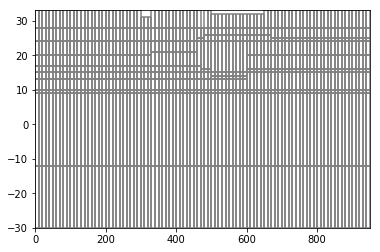

In [8]:
dis = mf.ModflowDis(
    tm, 
    nlay=nlay,
    nrow=nrow, 
    ncol=ncol, 
    delr=delr, 
    delc=delc, 
    top=top, 
    botm=botm, 
    nper=nper, 
    steady=steady
)

modelxsect= flopy.plot.ModelCrossSection(model=tm, line={'Row':0})
linecollection= modelxsect.plot_grid()

### Setup Basic-Package

Specify boundary conditions and starting heads.

We can set one value for all cells.

In [9]:
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)

for i in range ( 1, nlay ):
    ibound[ i, :, 0 ] = -1
    ibound[ i, :, -1 ] = -1

for k in range ( 47, 49 ):
    ibound[ 0, :, k ] = 0

strt = np.ones ( (nlay, nrow, ncol), dtype=np.int32 ) * 28
strt[ 1, :, 1 ] = 28
strt[ 1, :, -1 ] = 28

for i in range ( 30, 33 ):
    strt[ 0, :, i ] = 30
for j in range ( 50, 65 ):
    strt[ 0, :, j ] = 30
    
bas = mf.ModflowBas(tm, ibound=ibound, strt=strt)

#bas.plot()

### Setup Constant Head Boundaries

In [10]:
csv = pd.read_csv('SPA101.csv', delimiter=',')
chd_values = csv.iloc[ :, 2 ].values

#chd for each cell
#[lay, row, col, shead, ehead]
spchd = {}
spchd[0] = [
    [1, 0, 0, 28, 28 ], 
    [1, 0, ncol-1, 28, 28]
]

for layer in range (2, nlay):
    spchd[0].append ([layer, 0, 0, 28, 28 ])

for stress_period in range ( 1, nper ):
    spchd[stress_period] = [[1, 0, 0, chd_values[stress_period - 1], chd_values[stress_period]]]
    for layer in range (2, nlay):
        spchd[stress_period].append ([layer, 0, 0, chd_values[stress_period-1], chd_values[stress_period]])

chd = mf.ModflowChd(tm, stress_period_data=spchd)
#chd.plot()

### Setup General Head Boundaries

In [11]:
sp = {}
sp[0] = []
bas12_data = pd.read_csv ( 'Basin1&2.csv', delimiter=',' ).iloc[ :, 1 ].values
bas3_data = pd.read_csv ( 'Basin3.csv', delimiter=',' ).iloc[ :, 1 ].values

for col in range ( 30, 33 ):
    sp[ 0 ].append ( [ 0, 0, col, 31, 1450 ] )
    
for col in range ( 50, 65 ):
    sp[ 0 ].append ( [ 0, 0, col, 31, 1500 ] )
    
for stress_period in range ( 1,  nper ):
    sp[ stress_period ] = [ ]
    for col in range ( 30, 33 ):
        sp[ stress_period ].append ( [ 0, 0, col, 29 + 2.5*bas3_data[ stress_period - 1 ], 1800 ] )
    for col in range ( 50, 65 ):
        sp[ stress_period ].append ( [ 0, 0, col, 28.5 + 5*bas12_data[ stress_period - 1 ], 2000 ] )

ghb = mf.ModflowGhb (tm, stress_period_data=sp)
#ghb.plot()

### Setup Wells

In [12]:
# Pumping Well
wel_data = pd.read_csv('Pumping_well.csv', delimiter=',').iloc[:, -2].values

spwell = {}
spwell[0] = [8, 0, 41, 0]
for i in range(1, nper):
    spwell[i] = [8, 0, 41, -wel_data[i-1]]

wel = mf.ModflowWel(tm, stress_period_data=spwell, ipakcb=53)

#wel.plot()

### Setup Soil properties and Flow-Package

In [13]:
k1 = 2   # fine sand 1.728-7.776
k2 = 34  # middle sand 7.776-34.56
k3 = 41  # stone 34.56-103.68
k4 = 1   # clay
k5 = 45  # middle sand2
k6 = 6   # fine sand 1.728-7.776

# Set default hk-value value to k2
hk = np.ones((nlay, nrow, ncol)) * k2

# N1 layer
hk[0, :, :] = k1  # fine sand

# N2 layer
hk[1, :, :] = k2  # middle sand

# N3 layer
for i in range( 30, 60 ):
    hk[2, :, i] = k3  # sand & stone
for i in range( 55, 67 ):
    hk[2, :, i] = k4  # clay

#  N4 layer
hk[3, :, :] = k5  # middle sand2

# N5 layer
for i in range( 30, 44 ):
    hk[4, :, i] = k3  # sand & stone
for i in range( 44, 48 ):
    hk[4, :, i] = k4  # clay
for i in range( 48, 60 ):
    hk[4, :, i] = k3  # sand & stone
for i in range( 60, 65 ):
    hk[4, :, i] = k4  # clay

# N6 layer
hk[5, :, :] = k3
for i in range(36, 50 ):
    hk[5, :, i] = k6  # fine sand
for i in range( 50, 60 ):
    hk[5, :, i] = k3  # sand & stone
for i in range( 60, 65 ):
    hk[5, :, i] = k4  # clay

# 7 layer
hk[6, :, :] = k5  # middle sand2

# 8 layer
hk[7, :, :] = k5
for i in range(36 , 50 ):
    hk[7, :, i] = k6  # fine sand

# 9 layer
hk[8, :, :] = k5  # middle sand2

# 10 layer
hk[9, :, :] = k5  # middle sand2

# vertical HK
vk1 = 4
vk2 = 15
vk3 = 20
vk4 = 0.5
vk5 = 20
vk6 = 3

vka = np.ones((nlay, nrow, ncol), dtype=int) * vk3

# N1 layer
vka[0, :, :] = vk1  # fine sand

# N2 layer
vka[1, :, :] = vk2  # middle sand

# N3 layer
vka[2, :, :] = vk3
for i in range( 30, 55 ):
    vka[2, :, i] = vk3  # sand & stone
for i in range( 55, 67 ):
    vka[2, :, i] = vk4  # clay

# N4 layer
vka[3, :, :] = vk5  # middle sand2

# N5 layer
for i in range( 30, 44 ):
    vka[4, :, i] = vk3  # sand & stone
for i in range( 44, 48 ):
    vka[4, :, i] = vk4  # clay
for i in range( 48, 60 ):
    vka[4, :, i] = vk3  # sand & stone
for i in range( 60, 65 ):
    vka[4, :, i] = vk4  # clay

# N6 layer
vka[5, :, :] = vk3
for i in range( 36, 50 ):
    vka[5, :, i] = vk6  # fine sand
for i in range( 50, 60 ):
    vka[5, :, i] = vk3  # sand & stone
for i in range( 60, 65 ):
    vka[5, :, i] = vk4  # clay

# N7 layer
vka[6, :, :] = vk5  # middle sand2

# N8 layer
vka[7, :, :] = vk5
for i in range( 36, 50):
    vka[7, :, i] = vk6  # fine sand

# N9 layer
vka[8, :, :] = vk5  # middle sand2

# N10 layer
vka[9, :, :] = vk5  # middle sand2

laytyp = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
sy = 0.17
ss = 1e-4

lpf = mf.ModflowLpf(tm, laytyp=laytyp, hk=hk, layvka=0, vka=vka, sy=sy, ss=ss, ipakcb=53)

#lpf.plot()

### Head Observation Wells

In [14]:
obs = [ ]
col = [65,48,46]

name = ['SPA157','SPA168','SPA165']

for j in range (0,3):
    head = pd.read_csv(name[j]+'.csv',delimiter=',')
    t = head.iloc[ :, 0 ].values
    h = head.iloc[ :, 1 ].values
    sp = [ ]
    for i in range ( 0, len ( t ) ):
        sp.append ( [ t[ i ], h[ i ] ] )
    ho = flopy.modflow.HeadObservation (
    tm,
    obsname = name[j],
    layer= 1,
    row= 0,
    column= col[j],
    time_series_data= sp
    )
    obs.append ( ho )
       
hob = flopy.modflow.ModflowHob (
    tm,
    iuhobsv=1051,
    hobdry=-9999.,
    obs_data=obs
)

### Setup Solver Package and Output-control with defaults

In [15]:
budgetfile = '{}.cbb'.format(modelname)
budget_filerecord = [budgetfile]

oc = mf.ModflowOc(tm, 
                   save_every=True,
                   save_types=['print head', 'print budget','print drawdown', 'save head', 'save budget','save drawdown'],
                   budget_filerecord=budget_filerecord,
                   compact=True
                  )

pcg = mf.ModflowPcg (tm, rclose=1e-1)

lmt = flopy.modflow.ModflowLmt ( tm, output_file_name = modelname + '.ftl', output_file_header='extended',
                                 output_file_format='formatted')

### Write Model input and run the model

In [16]:
tm.write_input()
success = tm.run_model()

FloPy is using the following executable to run the model: C:\modflow\Packages\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: model.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/10/08 13:28:09

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     1    Gro

 Solving:  Stress period:   107    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:     1    Ground-Wa

 Solving:  Stress period:   227    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   228    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   230    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   233    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   237    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   239    Time step:     1    Ground-Wa

 Solving:  Stress period:   345    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   347    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   350    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   351    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   354    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   356    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:     1    Ground-Wa

 Solving:  Stress period:   466    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   467    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   468    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   469    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   470    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   471    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   472    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   473    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   474    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   475    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   476    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   477    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   478    Time step:     1    Ground-Wa

 Solving:  Stress period:   575    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   576    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   577    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   578    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   579    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   580    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   581    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   582    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   583    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   584    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   585    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   586    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   587    Time step:     1    Ground-Wa

 Solving:  Stress period:   690    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   691    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   692    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   693    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   694    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   695    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   696    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   697    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   698    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   699    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   700    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   701    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   702    Time step:     1    Ground-Wa

 Solving:  Stress period:   806    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   807    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   808    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   809    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   810    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   811    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   812    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   813    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   814    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   815    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   816    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   817    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   818    Time step:     1    Ground-Wa

 Solving:  Stress period:   913    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   914    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   915    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   916    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   917    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   918    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   919    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   920    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   921    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   922    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   923    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   924    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   925    Time step:     1    Ground-Wa

 Solving:  Stress period:  1028    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1029    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1030    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1031    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1032    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1033    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1034    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1035    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1036    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1037    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1038    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1039    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1040    Time step:     1    Ground-Wa

 Solving:  Stress period:  1140    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1141    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1142    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1143    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1144    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1145    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1146    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1147    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1148    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1149    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1150    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1151    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1152    Time step:     1    Ground-Wa

 Solving:  Stress period:  1256    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1257    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1258    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1259    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1260    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1261    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1262    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1263    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1264    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1265    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1266    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1267    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1268    Time step:     1    Ground-Wa

 Solving:  Stress period:  1367    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1368    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1369    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1370    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1371    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1372    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1373    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1374    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1375    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1376    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1377    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1378    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1379    Time step:     1    Ground-Wa

 Solving:  Stress period:  1482    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1483    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1484    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1485    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1486    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1487    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1488    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1489    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1490    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1491    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1492    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1493    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1494    Time step:     1    Ground-Wa

 Solving:  Stress period:  1595    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1596    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1597    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1598    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1599    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1600    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1601    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1602    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1603    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1604    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1605    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1606    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1607    Time step:     1    Ground-Wa

 Solving:  Stress period:  1709    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1710    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1711    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1712    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1713    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1714    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1715    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1716    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1717    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1718    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1719    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1720    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1721    Time step:     1    Ground-Wa

 Solving:  Stress period:  1822    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1823    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1824    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1825    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1826    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1827    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1828    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1829    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1830    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1831    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1832    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1833    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1834    Time step:     1    Ground-Wa

 Solving:  Stress period:  1938    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1939    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1940    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1941    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1942    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1943    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1944    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1945    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1946    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1947    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1948    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1949    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1950    Time step:     1    Ground-Wa

 Solving:  Stress period:  2047    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2048    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2049    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2050    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2051    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2052    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2053    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2054    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2055    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2056    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2057    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2058    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2059    Time step:     1    Ground-Wa

 Solving:  Stress period:  2172    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2173    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2174    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2175    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2176    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2177    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2178    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2179    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2180    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2181    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2182    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2183    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2184    Time step:     1    Ground-Wa

 Solving:  Stress period:  2289    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2290    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2291    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2292    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2293    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2294    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2295    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2296    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2297    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2298    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2299    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2300    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2301    Time step:     1    Ground-Wa

 Solving:  Stress period:  2404    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2405    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2406    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2407    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2408    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2409    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2410    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2411    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2412    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2413    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2414    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2415    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2416    Time step:     1    Ground-Wa

 Solving:  Stress period:  2519    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2520    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2521    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2522    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2523    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2524    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2525    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2526    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2527    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2528    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2529    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2530    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2531    Time step:     1    Ground-Wa

 Solving:  Stress period:  2643    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2644    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2645    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2646    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2647    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2648    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2649    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2650    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2651    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2652    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2653    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2654    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2655    Time step:     1    Ground-Wa

 Solving:  Stress period:  2759    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2760    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2761    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2762    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2763    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2764    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2765    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2766    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2767    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2768    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2769    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2770    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2771    Time step:     1    Ground-Wa

 Solving:  Stress period:  2883    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2884    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2885    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2886    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2887    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2888    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2889    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2890    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2891    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2892    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2893    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2894    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2895    Time step:     1    Ground-Wa

 Solving:  Stress period:  2999    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3000    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3001    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3002    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3003    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3004    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3005    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3006    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3007    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3008    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3009    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3010    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3011    Time step:     1    Ground-Wa

 Solving:  Stress period:  3109    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3110    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3111    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3112    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3113    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3114    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3115    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3116    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3117    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3118    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3119    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3120    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3121    Time step:     1    Ground-Wa

 Solving:  Stress period:  3222    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3223    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3224    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3225    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3226    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3227    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3228    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3229    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3230    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3231    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3232    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3233    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3234    Time step:     1    Ground-Wa

 Solving:  Stress period:  3338    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3339    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3340    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3341    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3342    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3343    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3344    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3345    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3346    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3347    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3348    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3349    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3350    Time step:     1    Ground-Wa

 Solving:  Stress period:  3449    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3450    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3451    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3452    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3453    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3454    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3455    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3456    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3457    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3458    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3459    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3460    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3461    Time step:     1    Ground-Wa

### Read and Plot Head Observations

c:\python36\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


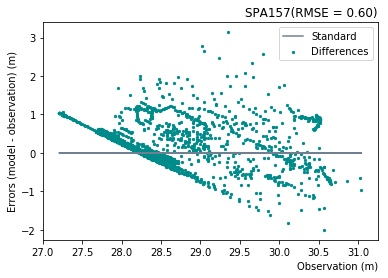

c:\python36\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


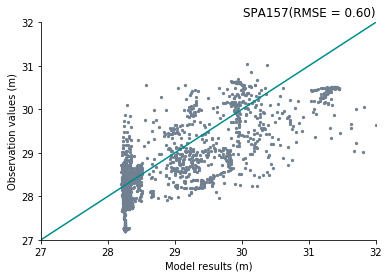

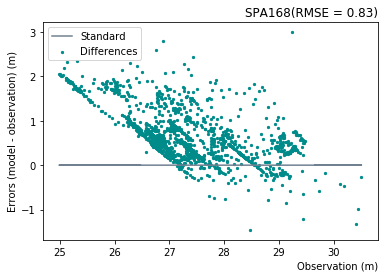

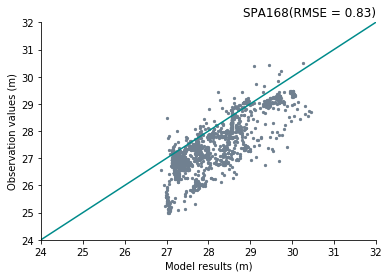

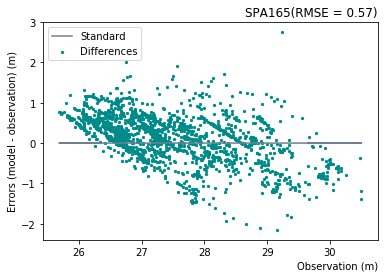

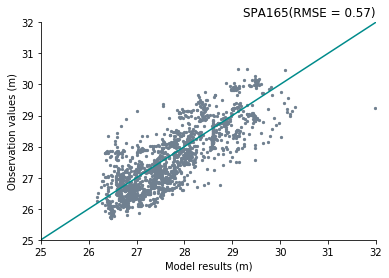

In [17]:
#observation wells

if os.path.isfile('model.hob.out'):
    obs = pd.read_csv('model.hob.out',delimiter='  ', header = 0, usecols = [0,1,2],index_col= 2)
else:
    os.chdir(workspace)
    obs = pd.read_csv('model.hob.out',delimiter='  ', header = 0, usecols = [0,1,2],index_col =2)

name = ['SPA157','SPA168','SPA165']

for j in range (0,3):
    index = [i for i in obs.index if name[j] in i]
    x = obs.loc[index]
    h1 = x.iloc[ :, 0 ].values
    h2 = x.iloc[ :, 1 ].values

    rmse = math.sqrt ( mse ( h1, h2 ) )
    rmse = '{:01.2f}'.format(rmse)
    u = []
    u = h1-h2
    a = h1 - h1
    plt.plot(h2,a,c='slategray',label='Standard')
    plt.scatter(h2,u,s=5,label='Differences',c = 'darkcyan')
    plt.legend(['Standard','Differences'])
    plt.xlabel('Observation (m)',horizontalalignment='right',x=1.0)
    plt.ylabel('Errors (model - observation) (m)')
    plt.title( name[j] + '(RMSE = ' + str ( rmse )+')', loc='right')
    plt.show()


    x = [int(min(h2)),32]
    y = [int(min(h2)),32]
    plt.scatter(h1,h2,s = 5,c='slategray')
    plt.plot(x,y,c='darkcyan')
    plt.ylim(int(min(h2)),32)
    plt.xlim(int(min(h2)),32)
    plt.xlabel('Model results (m)')
    plt.ylabel('Observation values (m)')
    plt.subplot().spines['right'].set_color('none')
    plt.subplot().spines['top'].set_color('none')
    plt.subplot()
    plt.title(name[j] + '(RMSE = ' + str ( rmse )+')', loc='right')
    plt.show()
    


    

### Read temperature data in the basins

In [18]:
if os.path.isfile('Basin-T.csv'):
    heat = pd.read_csv('Basin-T.csv',delimiter=',')
else:
    os.chdir("..")
    heat = pd.read_csv('Basin-T.csv',delimiter=',')

heat_basin = heat.iloc[:,3].values
#print (heat, heat_basin)

    


### MT3DMS 

In [19]:
mt = flopy.mt3d.Mt3dms(modelname = 'heat',version='mt3dms',  exe_name='mt3dms5b', 
                       model_ws = workspace, 
                       modflowmodel = tm, ftlfilename = modelname + ".ftl", verbose = True)

adv = mt3.Mt3dAdv(mt, mixelm = 0, percel = 0.75)
icbund = np.ones((nlay, nrow, ncol), dtype=np.int32)
icbund[:,:,0] = -1
icbund[:,:,-1] = -1
sconc_1 = np.ones((nlay, nrow, ncol)) * 10

for i in range ( 30, 55):
    sconc_1[ :, :, i ] = 16
for i in range ( 38, 45):
    sconc_1[ :, :, i ] = 13.5
for i in range ( 30, 33):
    sconc_1[ 0, :, i] = 12
for j in range ( 50, 65):
    sconc_1[ 0, :, j] = 12
    
obs = [ ( 8, 0, 41)]

btn = mt3.Mt3dBtn(mt,icbund= icbund, ncomp=1,mcomp=0, sconc = sconc_1, prsity = 0.17, species_names=['heat'], obs=obs,
                nprobs=1)
dsp = mt3.Mt3dDsp(mt, al=10, trpt=0.01,trpv = 0.01, dmcoef= 0.019891)
gcg = mt3.Mt3dGcg(mt, mxiter=100,iter1=25,isolve = 1,cclose = 1e-2)
rct = mt3.Mt3dRct(mt,isothm=1,ireact=0, prsity2=0.17, igetsc=0, sp1= 1.15e-3)

ssm_data = {}
ssm_data[0] = []

itype = flopy.mt3d.Mt3dSsm.itype_dict()

for i in range( 30, 33):
    ssm_data[0] = ssm_data[0]+ [[0, 0, i, 14 , itype[ 'GHB' ]]]
for i in range ( 50, 65):
    ssm_data[0].append( [ 0, 0, i, 14, itype[ 'GHB' ] ] )
    
for j in range (1,1955):
    ssm_data[ j ] = [ ]
    for i in range ( 30, 33):
         ssm_data[ j ].append ( [ 0, 0, i, heat_basin[ j - 1 ], itype[ 'GHB' ] ] )
    for i in range ( 50, 65):
         ssm_data[ j ].append ( [ 0, 0, i, heat_basin[ j - 1 ], itype[ 'GHB' ] ] )
for j in range(1955,nper):
    ssm_data[ j ] = [ ]
    for i in range ( 30, 33):
        ssm_data[ j ].append ( [ 0, 0, i, 14, itype[ 'GHB' ] ] )
    for i in range ( 50, 65):
        ssm_data[ j ].append ( [ 0, 0, i, 14, itype[ 'GHB' ] ] )


ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=ssm_data)

mt.write_input()
mt.run_model()


Specified value of ftlfree conflicts with FTL file format
Switching ftlfree from False to True
adding Package:  ADV
adding Package:  BTN
adding Package:  DSP
adding Package:  GCG
adding Package:  RCT
adding Package:  SSM

Writing packages:
   Package:  ADV
   Package:  BTN
   Package:  DSP
   Package:  GCG
   Package:  RCT
   Package:  SSM
 
FloPy is using the following executable to run the model: C:\modflow\Packages\mt3dms5b.exe
MT3DMS - Modular 3-D Multi-Species Transport Model [Version 5.30]
Developed at University of Alabama for U.S. Department of Defense

Using NAME File: heat.nam                                          

STRESS PERIOD NO.    1

TIME STEP NO.    1
FROM TIME =   0.0000     TO    1.0000    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1.0000    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5307E-01  [K,I,J]    2    1   31
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1759E-01  [K,I,J]    3    1   55
Outer Iter.  1  Inner Iter.  3:  Max. DC

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3815E-02  [K,I,J]    2    1   29
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.1456E-02  [K,I,J]    8    1   32

STRESS PERIOD NO.   73

TIME STEP NO.    1
FROM TIME =   72.000     TO    73.000    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   73.000    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3979E-02  [K,I,J]    2    1   29
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.1592E-02  [K,I,J]    8    1   32

STRESS PERIOD NO.   74

TIME STEP NO.    1
FROM TIME =   73.000     TO    74.000    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   74.000    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4553E-02  [K,I,J]    2    1   29
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.2019E-02  [K,I,J]    8    1   31

STRESS PERIOD NO.   75

TIME STEP NO.    1
FROM TIME =   74.000     TO    75.000    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   75.000    
Outer Iter.  1  Inner Iter. 

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1133E-01  [K,I,J]    2    1   34
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6825E-02  [K,I,J]    1    1   51
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.1186E-02  [K,I,J]    2    1   51

STRESS PERIOD NO.  160

TIME STEP NO.    1
FROM TIME =   159.00     TO    160.00    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   160.00    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1104E-01  [K,I,J]    2    1   34
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6007E-02  [K,I,J]    1    1   51
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.1044E-02  [K,I,J]    2    1   33

STRESS PERIOD NO.  161

TIME STEP NO.    1
FROM TIME =   160.00     TO    161.00    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   161.00    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1083E-01  [K,I,J]    2    1   34
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5456E-02  [K,I,J]    1    1   51
Outer Iter.  2  Inner Iter.  1:  Max

Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7403E-02  [K,I,J]    2    1   51
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.4166E-02  [K,I,J]    1    1   51

STRESS PERIOD NO.  231

TIME STEP NO.    1
FROM TIME =   230.00     TO    231.00    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   231.00    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1064E-01  [K,I,J]    2    1   48
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6687E-02  [K,I,J]    3    1   51
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.3297E-02  [K,I,J]    2    1   51

STRESS PERIOD NO.  232

TIME STEP NO.    1
FROM TIME =   231.00     TO    232.00    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   232.00    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1064E-01  [K,I,J]    2    1   48
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7315E-02  [K,I,J]    2    1   51
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.4188E-02  [K,I,J]    1    1   51

STRESS PERIOD NO.  233

TIME STEP N

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7944E-02  [K,I,J]    1    1   51
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.5604E-02  [K,I,J]    2    1   51

STRESS PERIOD NO.  316

TIME STEP NO.    1
FROM TIME =   315.00     TO    316.00    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   316.00    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8063E-02  [K,I,J]    1    1   51
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.5721E-02  [K,I,J]    2    1   51

STRESS PERIOD NO.  317

TIME STEP NO.    1
FROM TIME =   316.00     TO    317.00    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   317.00    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8318E-02  [K,I,J]    1    1   51
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.5886E-02  [K,I,J]    2    1   51

STRESS PERIOD NO.  318

TIME STEP NO.    1
FROM TIME =   317.00     TO    318.00    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   318.00    
Outer Iter.  1  Inner Iter. 

STRESS PERIOD NO.  400

TIME STEP NO.    1
FROM TIME =   399.00     TO    400.00    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   400.00    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7673E-02  [K,I,J]    1    1   56
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.5057E-02  [K,I,J]    2    1   51

STRESS PERIOD NO.  401

TIME STEP NO.    1
FROM TIME =   400.00     TO    401.00    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   401.00    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7491E-02  [K,I,J]    1    1   56
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.4981E-02  [K,I,J]    2    1   51

STRESS PERIOD NO.  402

TIME STEP NO.    1
FROM TIME =   401.00     TO    402.00    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   402.00    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7382E-02  [K,I,J]    1    1   56
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.4916E-02  [K,I,J]    2    1   51

STRESS PERIOD NO.  403

TIME

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   467.00    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4617E-02  [K,I,J]    6    1   37
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.1391E-02  [K,I,J]    8    1   32

STRESS PERIOD NO.  468

TIME STEP NO.    1
FROM TIME =   467.00     TO    468.00    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   468.00    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4594E-02  [K,I,J]    6    1   37
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.1348E-02  [K,I,J]    8    1   32

STRESS PERIOD NO.  469

TIME STEP NO.    1
FROM TIME =   468.00     TO    469.00    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   469.00    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4538E-02  [K,I,J]    6    1   37
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.1294E-02  [K,I,J]    8    1   32

STRESS PERIOD NO.  470

TIME STEP NO.    1
FROM TIME =   469.00     TO    470.00    

Transport Step:    1   Step 

FROM TIME =   541.00     TO    542.00    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   542.00    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8339E-02  [K,I,J]    2    1   50
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.4721E-02  [K,I,J]    3    1   52

STRESS PERIOD NO.  543

TIME STEP NO.    1
FROM TIME =   542.00     TO    543.00    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   543.00    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8480E-02  [K,I,J]    2    1   50
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.6106E-02  [K,I,J]    2    1   51

STRESS PERIOD NO.  544

TIME STEP NO.    1
FROM TIME =   543.00     TO    544.00    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   544.00    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9181E-02  [K,I,J]    1    1   51
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.7007E-02  [K,I,J]    2    1   51

STRESS PERIOD NO.  545

TIME STEP NO.    1
FROM TIME =   544.00     TO 

FROM TIME =   603.00     TO    604.00    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   604.00    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7312E-02  [K,I,J]    1    1   56
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.4526E-02  [K,I,J]    2    1   51

STRESS PERIOD NO.  605

TIME STEP NO.    1
FROM TIME =   604.00     TO    605.00    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   605.00    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6635E-02  [K,I,J]    2    1   50
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.2696E-02  [K,I,J]    2    1   51

STRESS PERIOD NO.  606

TIME STEP NO.    1
FROM TIME =   605.00     TO    606.00    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   606.00    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6509E-02  [K,I,J]    2    1   50
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.3838E-02  [K,I,J]    1    1   33

STRESS PERIOD NO.  607

TIME STEP NO.    1
FROM TIME =   606.00     TO 

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   662.00    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3111E-02  [K,I,J]    4    1   28
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.1072E-02  [K,I,J]    2    1   51

STRESS PERIOD NO.  663

TIME STEP NO.    1
FROM TIME =   662.00     TO    663.00    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   663.00    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5103E-02  [K,I,J]    5    1   37
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.1740E-02  [K,I,J]    2    1   51

STRESS PERIOD NO.  664

TIME STEP NO.    1
FROM TIME =   663.00     TO    664.00    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   664.00    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4826E-02  [K,I,J]    3    1   38
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.1740E-02  [K,I,J]    2    1   51

STRESS PERIOD NO.  665

TIME STEP NO.    1
FROM TIME =   664.00     TO    665.00    

Transport Step:    1   Step 

FROM TIME =   722.00     TO    723.00    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   723.00    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1154E-01  [K,I,J]    2    1   34
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5355E-02  [K,I,J]    2    1   33
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.1032E-02  [K,I,J]    1    1   33

STRESS PERIOD NO.  724

TIME STEP NO.    1
FROM TIME =   723.00     TO    724.00    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   724.00    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1139E-01  [K,I,J]    2    1   34
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5143E-02  [K,I,J]    2    1   33
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.9680E-03  [K,I,J]    1    1   33

STRESS PERIOD NO.  725

TIME STEP NO.    1
FROM TIME =   724.00     TO    725.00    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   725.00    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1114E-01  [K,I,J]    2    

Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.2506E-02  [K,I,J]    2    1   51

STRESS PERIOD NO.  775

TIME STEP NO.    1
FROM TIME =   774.00     TO    775.00    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   775.00    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5174E-02  [K,I,J]    2    1   29
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.2295E-02  [K,I,J]    8    1   32

STRESS PERIOD NO.  776

TIME STEP NO.    1
FROM TIME =   775.00     TO    776.00    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   776.00    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5108E-02  [K,I,J]    2    1   29
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.2430E-02  [K,I,J]    2    1   51

STRESS PERIOD NO.  777

TIME STEP NO.    1
FROM TIME =   776.00     TO    777.00    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   777.00    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5340E-02  [K,I,J]    1    1   65
Outer Iter.  2  Inner Iter. 

Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.2222E-02  [K,I,J]    2    1   51

STRESS PERIOD NO.  850

TIME STEP NO.    1
FROM TIME =   849.00     TO    850.00    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   850.00    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5481E-02  [K,I,J]    1    1   33
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.2882E-02  [K,I,J]    2    1   51

STRESS PERIOD NO.  851

TIME STEP NO.    1
FROM TIME =   850.00     TO    851.00    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   851.00    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6387E-02  [K,I,J]    6    1   38
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.3623E-02  [K,I,J]    2    1   51

STRESS PERIOD NO.  852

TIME STEP NO.    1
FROM TIME =   851.00     TO    852.00    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   852.00    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6058E-02  [K,I,J]    1    1   33
Outer Iter.  2  Inner Iter. 

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1044E-01  [K,I,J]    2    1   35
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7021E-02  [K,I,J]    2    1   51
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.4505E-02  [K,I,J]    1    1   51

STRESS PERIOD NO.  928

TIME STEP NO.    1
FROM TIME =   927.00     TO    928.00    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   928.00    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1063E-01  [K,I,J]    2    1   35
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8804E-02  [K,I,J]    1    1   51
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.4702E-02  [K,I,J]    2    1   51

STRESS PERIOD NO.  929

TIME STEP NO.    1
FROM TIME =   928.00     TO    929.00    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   929.00    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1023E-01  [K,I,J]    2    1   35
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7440E-02  [K,I,J]    2    1   51
Outer Iter.  2  Inner Iter.  1:  Max

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4158E-02  [K,I,J]    2    1   38
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.1269E-02  [K,I,J]    6    1   51

STRESS PERIOD NO.  995

TIME STEP NO.    1
FROM TIME =   994.00     TO    995.00    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   995.00    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3566E-02  [K,I,J]    2    1   38
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.1237E-02  [K,I,J]    6    1   53

STRESS PERIOD NO.  996

TIME STEP NO.    1
FROM TIME =   995.00     TO    996.00    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   996.00    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3334E-02  [K,I,J]    2    1   38
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.1180E-02  [K,I,J]    6    1   53

STRESS PERIOD NO.  997

TIME STEP NO.    1
FROM TIME =   996.00     TO    997.00    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   997.00    
Outer Iter.  1  Inner Iter. 

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1137E-01  [K,I,J]    2    1   50
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7728E-02  [K,I,J]    1    1   51
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.3091E-02  [K,I,J]    2    1   51

STRESS PERIOD NO. 1083

TIME STEP NO.    1
FROM TIME =   1082.0     TO    1083.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1083.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9545E-02  [K,I,J]    2    1   30
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.5908E-02  [K,I,J]    2    1   51

STRESS PERIOD NO. 1084

TIME STEP NO.    1
FROM TIME =   1083.0     TO    1084.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1084.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8615E-02  [K,I,J]    1    1   51
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.6929E-02  [K,I,J]    2    1   51

STRESS PERIOD NO. 1085

TIME STEP NO.    1
FROM TIME =   1084.0     TO    1085.0    

Transport Step:    1   Step 


Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1170.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6517E-02  [K,I,J]    3    1   49
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.5115E-02  [K,I,J]    2    1   51

STRESS PERIOD NO. 1171

TIME STEP NO.    1
FROM TIME =   1170.0     TO    1171.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1171.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6938E-02  [K,I,J]    2    1   48
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.5788E-02  [K,I,J]    2    1   51

STRESS PERIOD NO. 1172

TIME STEP NO.    1
FROM TIME =   1171.0     TO    1172.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1172.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1096E-01  [K,I,J]    1    1   57
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6955E-02  [K,I,J]    2    1   51
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.3452E-02  [K,I,J]    1    1   51

STRESS PERIOD NO. 1173

TIME STEP 

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6848E-02  [K,I,J]    1    1   55
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.2759E-02  [K,I,J]    1    1   55

STRESS PERIOD NO. 1203

TIME STEP NO.    1
FROM TIME =   1202.0     TO    1203.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1203.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4541E-02  [K,I,J]    4    1   47
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.1804E-02  [K,I,J]    3    1   55

STRESS PERIOD NO. 1204

TIME STEP NO.    1
FROM TIME =   1203.0     TO    1204.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1204.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7016E-02  [K,I,J]    1    1   60
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.2076E-02  [K,I,J]    5    1   49

STRESS PERIOD NO. 1205

TIME STEP NO.    1
FROM TIME =   1204.0     TO    1205.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1205.0    
Outer Iter.  1  Inner Iter. 

FROM TIME =   1275.0     TO    1276.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1276.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1098E-01  [K,I,J]    1    1   51
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6321E-02  [K,I,J]    2    1   51
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.1759E-02  [K,I,J]    3    1   51

STRESS PERIOD NO. 1277

TIME STEP NO.    1
FROM TIME =   1276.0     TO    1277.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1277.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9431E-02  [K,I,J]    1    1   65
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.5118E-02  [K,I,J]    2    1   51

STRESS PERIOD NO. 1278

TIME STEP NO.    1
FROM TIME =   1277.0     TO    1278.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1278.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1150E-01  [K,I,J]    1    1   32
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5294E-02  [K,I,J]    2    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1342.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9787E-02  [K,I,J]    3    1   51
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.6219E-02  [K,I,J]    1    1   51

STRESS PERIOD NO. 1343

TIME STEP NO.    1
FROM TIME =   1342.0     TO    1343.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1343.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9031E-02  [K,I,J]    2    1   29
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.6371E-02  [K,I,J]    1    1   51

STRESS PERIOD NO. 1344

TIME STEP NO.    1
FROM TIME =   1343.0     TO    1344.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1344.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6725E-02  [K,I,J]    2    1   51
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.5186E-02  [K,I,J]    1    1   51

STRESS PERIOD NO. 1345

TIME STEP NO.    1
FROM TIME =   1344.0     TO    1345.0    

Transport Step:    1   Step 

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1409.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1023E-01  [K,I,J]    6    1   37
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3785E-02  [K,I,J]    6    1   51
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.1525E-02  [K,I,J]    2    1   51

STRESS PERIOD NO. 1410

TIME STEP NO.    1
FROM TIME =   1409.0     TO    1410.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1410.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1027E-01  [K,I,J]    2    1   38
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4354E-02  [K,I,J]    2    1   33
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.1325E-02  [K,I,J]    1    1   33

STRESS PERIOD NO. 1411

TIME STEP NO.    1
FROM TIME =   1410.0     TO    1411.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1411.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1025E-01  [K,I,J]    6    1   38
Outer Iter.  1  Inner Iter.  2:  Max

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1489.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8602E-02  [K,I,J]    1    1   51
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.5586E-02  [K,I,J]    2    1   51

STRESS PERIOD NO. 1490

TIME STEP NO.    1
FROM TIME =   1489.0     TO    1490.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1490.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8447E-02  [K,I,J]    1    1   51
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.5543E-02  [K,I,J]    2    1   51

STRESS PERIOD NO. 1491

TIME STEP NO.    1
FROM TIME =   1490.0     TO    1491.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1491.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7600E-02  [K,I,J]    1    1   33
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.4521E-02  [K,I,J]    2    1   51

STRESS PERIOD NO. 1492

TIME STEP NO.    1
FROM TIME =   1491.0     TO    1492.0    

Transport Step:    1   Step 

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1577.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3278E-02  [K,I,J]    2    1   40
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.1209E-02  [K,I,J]    2    1   51

STRESS PERIOD NO. 1578

TIME STEP NO.    1
FROM TIME =   1577.0     TO    1578.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1578.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2367E-02  [K,I,J]    2    1   40
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.1207E-02  [K,I,J]    2    1   51

STRESS PERIOD NO. 1579

TIME STEP NO.    1
FROM TIME =   1578.0     TO    1579.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1579.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2277E-02  [K,I,J]    1    1   33
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.1229E-02  [K,I,J]    2    1   51

STRESS PERIOD NO. 1580

TIME STEP NO.    1
FROM TIME =   1579.0     TO    1580.0    

Transport Step:    1   Step 

FROM TIME =   1670.0     TO    1671.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1671.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9404E-02  [K,I,J]    2    1   34
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.5135E-02  [K,I,J]    2    1   33

STRESS PERIOD NO. 1672

TIME STEP NO.    1
FROM TIME =   1671.0     TO    1672.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1672.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9328E-02  [K,I,J]    2    1   34
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.5675E-02  [K,I,J]    2    1   33

STRESS PERIOD NO. 1673

TIME STEP NO.    1
FROM TIME =   1672.0     TO    1673.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1673.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1153E-01  [K,I,J]    1    1   56
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7348E-02  [K,I,J]    2    1   33
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.2660E-02  [K,I,J]    3    

STRESS PERIOD NO. 1771

TIME STEP NO.    1
FROM TIME =   1770.0     TO    1771.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1771.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8087E-02  [K,I,J]    1    1   61
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.2798E-02  [K,I,J]    2    1   51

STRESS PERIOD NO. 1772

TIME STEP NO.    1
FROM TIME =   1771.0     TO    1772.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1772.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6139E-02  [K,I,J]    2    1   45
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.2972E-02  [K,I,J]    2    1   51

STRESS PERIOD NO. 1773

TIME STEP NO.    1
FROM TIME =   1772.0     TO    1773.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1773.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5402E-02  [K,I,J]    8    1   47
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.2949E-02  [K,I,J]    2    1   51

STRESS PERIOD NO. 1774

TIME

Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.2200E-02  [K,I,J]    2    1   65

STRESS PERIOD NO. 1861

TIME STEP NO.    1
FROM TIME =   1860.0     TO    1861.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1861.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1205E-01  [K,I,J]    1    1   56
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6138E-02  [K,I,J]    2    1   52
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.1767E-02  [K,I,J]    5    1   50

STRESS PERIOD NO. 1862

TIME STEP NO.    1
FROM TIME =   1861.0     TO    1862.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1862.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1144E-01  [K,I,J]    1    1   56
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6044E-02  [K,I,J]    2    1   51
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.1757E-02  [K,I,J]    1    1   51

STRESS PERIOD NO. 1863

TIME STEP NO.    1
FROM TIME =   1862.0     TO    1863.0    

Transport Step:    1   Step 

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1954.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3122E-02  [K,I,J]    2    1   27
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.1132E-02  [K,I,J]    2    1   33

STRESS PERIOD NO. 1955

TIME STEP NO.    1
FROM TIME =   1954.0     TO    1955.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1955.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2677E-02  [K,I,J]    6    1   38
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.9133E-03  [K,I,J]    2    1   33

STRESS PERIOD NO. 1956

TIME STEP NO.    1
FROM TIME =   1955.0     TO    1956.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1956.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4119E-01  [K,I,J]    1    1   33
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1532E-01  [K,I,J]    2    1   51
Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6710E-02  [K,I,J]    3    1   51
Outer Iter.  2  Inner Iter.  1:  Max

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   2028.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2126E-02  [K,I,J]    4    1   36
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.7382E-03  [K,I,J]    6    1   51

STRESS PERIOD NO. 2029

TIME STEP NO.    1
FROM TIME =   2028.0     TO    2029.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   2029.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2449E-02  [K,I,J]    2    1   36
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.1193E-02  [K,I,J]    2    1   51

STRESS PERIOD NO. 2030

TIME STEP NO.    1
FROM TIME =   2029.0     TO    2030.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   2030.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2159E-02  [K,I,J]    1    1   65
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.8264E-03  [K,I,J]    1    1   52

STRESS PERIOD NO. 2031

TIME STEP NO.    1
FROM TIME =   2030.0     TO    2031.0    

Transport Step:    1   Step 

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   2104.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2906E-02  [K,I,J]    2    1   43
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.1397E-02  [K,I,J]    2    1   51

STRESS PERIOD NO. 2105

TIME STEP NO.    1
FROM TIME =   2104.0     TO    2105.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   2105.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2792E-02  [K,I,J]    2    1   43
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.1346E-02  [K,I,J]    2    1   51

STRESS PERIOD NO. 2106

TIME STEP NO.    1
FROM TIME =   2105.0     TO    2106.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   2106.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2623E-02  [K,I,J]    2    1   43
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.1285E-02  [K,I,J]    2    1   51

STRESS PERIOD NO. 2107

TIME STEP NO.    1
FROM TIME =   2106.0     TO    2107.0    

Transport Step:    1   Step 

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7738E-03  [K,I,J]   10    1   42
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.2254E-03  [K,I,J]    8    1   42

STRESS PERIOD NO. 2168

TIME STEP NO.    1
FROM TIME =   2167.0     TO    2168.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   2168.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8312E-03  [K,I,J]   10    1   42
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.2347E-03  [K,I,J]    8    1   42

STRESS PERIOD NO. 2169

TIME STEP NO.    1
FROM TIME =   2168.0     TO    2169.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   2169.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8346E-03  [K,I,J]   10    1   42
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.2355E-03  [K,I,J]    8    1   42

STRESS PERIOD NO. 2170

TIME STEP NO.    1
FROM TIME =   2169.0     TO    2170.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   2170.0    
Outer Iter.  1  Inner Iter. 

STRESS PERIOD NO. 2256

TIME STEP NO.    1
FROM TIME =   2255.0     TO    2256.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   2256.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3244E-03  [K,I,J]   10    1   44
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.9161E-04  [K,I,J]    8    1   41

STRESS PERIOD NO. 2257

TIME STEP NO.    1
FROM TIME =   2256.0     TO    2257.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   2257.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4939E-03  [K,I,J]    1    1   63
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.9197E-04  [K,I,J]    8    1   42

STRESS PERIOD NO. 2258

TIME STEP NO.    1
FROM TIME =   2257.0     TO    2258.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   2258.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3433E-03  [K,I,J]   10    1   44
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.8541E-04  [K,I,J]    8    1   41

STRESS PERIOD NO. 2259

TIME

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2687E-03  [K,I,J]    1    1   60
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.7039E-04  [K,I,J]    8    1   41

STRESS PERIOD NO. 2345

TIME STEP NO.    1
FROM TIME =   2344.0     TO    2345.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   2345.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2974E-03  [K,I,J]    2    1   23
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.7570E-04  [K,I,J]    8    1   42

STRESS PERIOD NO. 2346

TIME STEP NO.    1
FROM TIME =   2345.0     TO    2346.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   2346.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3610E-03  [K,I,J]    2    1   23
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.7904E-04  [K,I,J]    8    1   41

STRESS PERIOD NO. 2347

TIME STEP NO.    1
FROM TIME =   2346.0     TO    2347.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   2347.0    
Outer Iter.  1  Inner Iter. 

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2946E-03  [K,I,J]    4    1   66
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.9763E-04  [K,I,J]    8    1   42

STRESS PERIOD NO. 2446

TIME STEP NO.    1
FROM TIME =   2445.0     TO    2446.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   2446.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2978E-03  [K,I,J]    4    1   66
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.9584E-04  [K,I,J]    8    1   42

STRESS PERIOD NO. 2447

TIME STEP NO.    1
FROM TIME =   2446.0     TO    2447.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   2447.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3026E-03  [K,I,J]    4    1   66
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.9638E-04  [K,I,J]    8    1   42

STRESS PERIOD NO. 2448

TIME STEP NO.    1
FROM TIME =   2447.0     TO    2448.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   2448.0    
Outer Iter.  1  Inner Iter. 


STRESS PERIOD NO. 2546

TIME STEP NO.    1
FROM TIME =   2545.0     TO    2546.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   2546.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5736E-03  [K,I,J]    8    1   61
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.2047E-03  [K,I,J]    6    1   60

STRESS PERIOD NO. 2547

TIME STEP NO.    1
FROM TIME =   2546.0     TO    2547.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   2547.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5957E-03  [K,I,J]    8    1   61
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.2161E-03  [K,I,J]    6    1   60

STRESS PERIOD NO. 2548

TIME STEP NO.    1
FROM TIME =   2547.0     TO    2548.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   2548.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3967E-03  [K,I,J]    1    1   65
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.9239E-04  [K,I,J]    6    1   60

STRESS PERIOD NO. 2549

TIM


STRESS PERIOD NO. 2626

TIME STEP NO.    1
FROM TIME =   2625.0     TO    2626.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   2626.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1509E-03  [K,I,J]    1    1   60
Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

STRESS PERIOD NO. 2627

TIME STEP NO.    1
FROM TIME =   2626.0     TO    2627.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   2627.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1500E-03  [K,I,J]    1    1   60
Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

STRESS PERIOD NO. 2628

TIME STEP NO.    1
FROM TIME =   2627.0     TO    2628.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   2628.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1495E-03  [K,I,J]    1    1   60
Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

STRESS PERIOD NO. 2629

TIM

FROM TIME =   2713.0     TO    2714.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   2714.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1608E-03  [K,I,J]    7    1   65
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.1740E-04  [K,I,J]    8    1   42

STRESS PERIOD NO. 2715

TIME STEP NO.    1
FROM TIME =   2714.0     TO    2715.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   2715.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1618E-03  [K,I,J]    7    1   65
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.1717E-04  [K,I,J]    8    1   42

STRESS PERIOD NO. 2716

TIME STEP NO.    1
FROM TIME =   2715.0     TO    2716.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   2716.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1615E-03  [K,I,J]    7    1   65
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.1729E-04  [K,I,J]    8    1   42

STRESS PERIOD NO. 2717

TIME STEP NO.    1
FROM TIME =   2716.0     TO 

Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1513E-03  [K,I,J]    8    1   22
Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

STRESS PERIOD NO. 2800

TIME STEP NO.    1
FROM TIME =   2799.0     TO    2800.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   2800.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1200E-03  [K,I,J]    8    1   22
Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

STRESS PERIOD NO. 2801

TIME STEP NO.    1
FROM TIME =   2800.0     TO    2801.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   2801.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1327E-03  [K,I,J]    6    1   66
Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

STRESS PERIOD NO. 2802

TIME STEP NO.    1
FROM TIME =   2801.0     TO    2802.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   2802.0    
Outer Iter.  1  Inner Iter. 

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   2875.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1592E-03  [K,I,J]    4    1   21
Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

STRESS PERIOD NO. 2876

TIME STEP NO.    1
FROM TIME =   2875.0     TO    2876.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   2876.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1588E-03  [K,I,J]    4    1   21
Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

STRESS PERIOD NO. 2877

TIME STEP NO.    1
FROM TIME =   2876.0     TO    2877.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   2877.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1578E-03  [K,I,J]    4    1   21
Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

STRESS PERIOD NO. 2878

TIME STEP NO.    1
FROM TIME =   2877.0     TO    2878.0    

Transport Step:    1   Step 

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   2951.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1783E-03  [K,I,J]    4    1   20
Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

STRESS PERIOD NO. 2952

TIME STEP NO.    1
FROM TIME =   2951.0     TO    2952.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   2952.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1987E-03  [K,I,J]    2    1   20
Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

STRESS PERIOD NO. 2953

TIME STEP NO.    1
FROM TIME =   2952.0     TO    2953.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   2953.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1913E-03  [K,I,J]    4    1   20
Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

STRESS PERIOD NO. 2954

TIME STEP NO.    1
FROM TIME =   2953.0     TO    2954.0    

Transport Step:    1   Step 

FROM TIME =   3026.0     TO    3027.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   3027.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9060E-04  [K,I,J]    7    1   65
Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

STRESS PERIOD NO. 3028

TIME STEP NO.    1
FROM TIME =   3027.0     TO    3028.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   3028.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9203E-04  [K,I,J]    7    1   65
Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

STRESS PERIOD NO. 3029

TIME STEP NO.    1
FROM TIME =   3028.0     TO    3029.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   3029.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9215E-04  [K,I,J]    7    1   65
Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

STRESS PERIOD NO. 3030

TIME STEP NO.    1
FROM TIME =   3029.0     TO 

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   3128.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1755E-03  [K,I,J]    8    1   61
Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

STRESS PERIOD NO. 3129

TIME STEP NO.    1
FROM TIME =   3128.0     TO    3129.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   3129.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1749E-03  [K,I,J]    8    1   61
Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

STRESS PERIOD NO. 3130

TIME STEP NO.    1
FROM TIME =   3129.0     TO    3130.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   3130.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1746E-03  [K,I,J]    8    1   61
Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

STRESS PERIOD NO. 3131

TIME STEP NO.    1
FROM TIME =   3130.0     TO    3131.0    

Transport Step:    1   Step 

FROM TIME =   3218.0     TO    3219.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   3219.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1431E-03  [K,I,J]    8    1   61
Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

STRESS PERIOD NO. 3220

TIME STEP NO.    1
FROM TIME =   3219.0     TO    3220.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   3220.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1432E-03  [K,I,J]    8    1   61
Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

STRESS PERIOD NO. 3221

TIME STEP NO.    1
FROM TIME =   3220.0     TO    3221.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   3221.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1427E-03  [K,I,J]    8    1   61
Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

STRESS PERIOD NO. 3222

TIME STEP NO.    1
FROM TIME =   3221.0     TO 

Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.1029E-03  [K,I,J]    6    1   60

STRESS PERIOD NO. 3318

TIME STEP NO.    1
FROM TIME =   3317.0     TO    3318.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   3318.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3612E-03  [K,I,J]    8    1   61
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.1013E-03  [K,I,J]    6    1   60

STRESS PERIOD NO. 3319

TIME STEP NO.    1
FROM TIME =   3318.0     TO    3319.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   3319.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2469E-02  [K,I,J]    1    1   60
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.1596E-03  [K,I,J]    6    1   60

STRESS PERIOD NO. 3320

TIME STEP NO.    1
FROM TIME =   3319.0     TO    3320.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   3320.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8871E-03  [K,I,J]    8    1   61
Outer Iter.  2  Inner Iter. 

Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.8214E-04  [K,I,J]    6    1   60

STRESS PERIOD NO. 3394

TIME STEP NO.    1
FROM TIME =   3393.0     TO    3394.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   3394.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3143E-03  [K,I,J]   10    1   58
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.8166E-04  [K,I,J]    6    1   60

STRESS PERIOD NO. 3395

TIME STEP NO.    1
FROM TIME =   3394.0     TO    3395.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   3395.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5949E-03  [K,I,J]    1    1   65
Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.6956E-04  [K,I,J]    3    1   55

STRESS PERIOD NO. 3396

TIME STEP NO.    1
FROM TIME =   3395.0     TO    3396.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   3396.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2331E-02  [K,I,J]    1    1   60
Outer Iter.  2  Inner Iter. 


TIME STEP NO.    1
FROM TIME =   3471.0     TO    3472.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   3472.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1581E-03  [K,I,J]    7    1   66
Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

STRESS PERIOD NO. 3473

TIME STEP NO.    1
FROM TIME =   3472.0     TO    3473.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   3473.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1221E-03  [K,I,J]    1    1   62
Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

STRESS PERIOD NO. 3474

TIME STEP NO.    1
FROM TIME =   3473.0     TO    3474.0    

Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   3474.0    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1212E-03  [K,I,J]    1    1   62
Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

STRESS PERIOD NO. 3475

TIME STEP NO.    1
FROM TIM

(False, [])

### Read MT3DMs Output Files

In [20]:
if os.path.isfile('N5_T.csv'):
    n = pd.read_csv('N5_T.csv',delimiter=',',header=0,skip_blank_lines=True,index_col=0)
    w = pd.read_csv('N6_T.csv',delimiter=',',header=0, index_col=0)
else:
    os.chdir("..")
    n = pd.read_csv('N5_T.csv',delimiter=',',header=0,skip_blank_lines=True,index_col=0)
    w = pd.read_csv('N6_T.csv',delimiter=',',header=0 ,index_col=0)
if os.path.isfile('MT3D001.OBS'):
    t = pd.read_csv('MT3D001.OBS',delimiter=' ', nrows=2000,skiprows=[0,1],skipinitialspace=True,skip_blank_lines=True,usecols=[1,2],index_col=0)

else:
    os.chdir(workspace)
    t = pd.read_csv('MT3D001.OBS',delimiter=' ', nrows=2000,skiprows=[0,1],skipinitialspace=True,skip_blank_lines=True,usecols=[1,2],index_col=0)
#print (n,w,t) 


### Plot MT3DMS Output Files

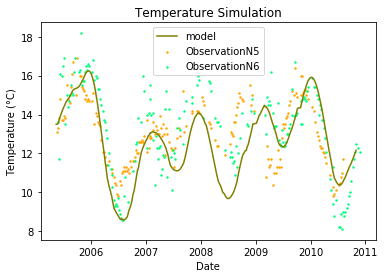

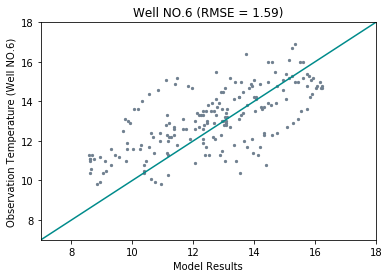

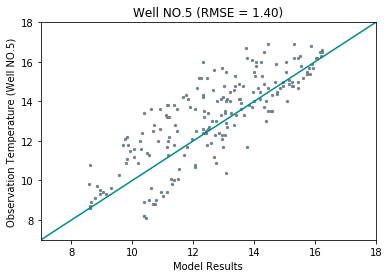

In [21]:
t1 = t.index.values
y1 = []
for i in t1:
    y1.append([datetime.date(2005,5,11)+datetime.timedelta(i-1)])
t2 = t.iloc[:,0].values


n1 = n.index.values
y2 = []
for i in n1:
    y2.append([datetime.date(2005,5,11)+datetime.timedelta(np.float64(i-1))])
n2 = n.iloc[:,0].values

w1 = w.index.values
y3 = []
for i in w1:
    y3.append([datetime.date(2005,5,11)+datetime.timedelta(np.float64(i-1))])
w2 = w.iloc[:,0].values

plt.plot(y1,t2,c='olive')
plt.scatter(y2,n2,c='orange',s=2)
plt.scatter(y3,w2,c='springgreen',s=2)
plt.legend(['model','ObservationN5','ObservationN6'])
plt.xlabel ( 'Date' )
plt.ylabel ( 'Temperature (°C)' )
plt.title('Temperature Simulation')
#plt.savefig('temperature.png')
plt.show()
plt.close()

x = t.join(n, how='inner')
v1 = x.iloc[:,0].values
v2 = x.iloc[:,1].values
x1 = [7,18]
y1 = [7,18]
plt.scatter(v1,v2,s = 5,c='slategray')
plt.plot(x1,y1,c='darkcyan')
plt.ylim(7,18)
plt.xlim(7,18)
plt.xlabel ( 'Model Results' )
plt.ylabel ( 'Observation Temperature (Well NO.6)' )
rmse =  math.sqrt ( mse ( v1, v2 ) )
rmse = '{:01.2f}'.format(rmse)
plt.title('Well NO.6 (RMSE = ' + str (rmse)+')')
plt.show()
plt.close()


x = t.join(w, how='inner')
v1=x.iloc[:,0].values
v2 = x.iloc[:,1].values
x = [7,18]
y = [7,18]
plt.scatter(v1,v2,s = 5,c='slategray')
plt.plot(x,y,c='darkcyan')
plt.ylim(7,18)
plt.xlim(7,18)
plt.xlabel ( 'Model Results' )
plt.ylabel ( 'Observation Temperature (Well NO.5)' )
rmse =  math.sqrt ( mse ( v1, v2 ) )
rmse = '{:01.2f}'.format(rmse)
plt.title('Well NO.5 (RMSE = ' + str (rmse)+')')
plt.show()
plt.close()